In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import random

torch.manual_seed(41)
random.seed(45)

In [ ]:
cd /content/drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.fc = nn.Sequential(
        nn.Linear(1*28*28, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    output = self.fc(x)
    return output

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.fc = nn.Sequential(
        nn.Linear(100, 128),
        nn.ReLU(),
        nn.Linear(128, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 1*28*28),
        nn.Tanh(),
    )

  def forward(self, x):
    output = self.fc(x)
    return output

In [ ]:
#데이터 부르기
train = np.loadtxt("mnist_train.csv", delimiter=',', dtype=float)
test = np.loadtxt("mnist_test.csv", delimiter=',', dtype=float)
print(train.shape)
print(test.shape)

(60000, 785)
(10000, 785)


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# tanh를 사용했기 때문에 -1~1사이로 Normalization
# 성능 향상을 위해 train data에 가우시안 노이즈 추가
train_real = ((torch.Tensor(train[:, 1:])-127.5)/127.5).to(device)
gaus_noise = torch.tensor(np.random.normal(0, 1, train_real.size()), dtype=torch.float)
test_real = torch.Tensor(test[:, 1:]).to(device)

In [ ]:
model_D = Discriminator().to(device)
model_G = Generator().to(device)

In [ ]:
loss_function_ = nn.BCELoss().to(device)

optim_D = optim.Adam(model_D.parameters(), lr=0.0001, betas=(0.9, 0.999))
optim_G = optim.Adam(model_G.parameters(), lr=0.0002, betas=(0.9, 0.999))

In [ ]:
real_label_ = 1
fake_label_ = 0

In [ ]:
noise = torch.randn(60000, 100).to(device)
print(type(noise), noise.shape, train_real.shape)

<class 'torch.Tensor'> torch.Size([60000, 100]) torch.Size([60000, 784])


In [ ]:
# fake_images_= model_G(noise)

# real_output_ = model_D(train_real)
# fake_output_ = model_D(fake_images_)
# real_label_ = torch.ones_like(real_output_)
# fake_label_ = torch.zeros_like(fake_output_)

In [ ]:
# print(fake_images_.shape)
# print(real_output_.shape)
# print(fake_output_.shape)
# print(real_label_.shape)
# print(fake_label_.shape)

In [ ]:
d_loss = []
g_loss = []
for epoch in range(800):
  for batch in range(60):
    fake_images_= model_G(noise[batch*1000:(batch+1)*1000, :])

    real_output_ = model_D(train_real[batch*1000:(batch+1)*1000, :])
    fake_output_ = model_D(fake_images_)

    # real_label_ = torch.ones_like(real_output_)
    # fake_label_ = torch.zeros_like(fake_output_)
    cost_D = (loss_function_(real_output_, torch.ones_like(real_output_)) + loss_function_(fake_output_, torch.zeros_like(fake_output_)))/2
    if epoch % 8 != 1 : # epoch % 8 !=
      model_D.zero_grad()
      cost_D.backward(retain_graph=True)
      optim_D.step()


    cost_G = loss_function_(fake_output_, torch.ones_like(fake_output_))
    model_G.zero_grad()
    cost_G.backward()
    optim_G.step()


  d_loss.append(cost_D.item())
  g_loss.append(cost_G.item())

  if epoch == 0 or epoch % 25 == 24:
    torch.save(model_D.state_dict(), "./ckpt_gan/Dis_{}.pt".format(epoch+1))
    torch.save(model_G.state_dict(), "./ckpt_gan/Gen_{}.pt".format(epoch+1))
    print("Epoch: {0}, cost D: {1}, cost G: {2}".format(epoch+1, cost_D.item(), cost_G.item()))

Epoch: 1, cost D: 0.4224105477333069, cost G: 1.4140996932983398
Epoch: 25, cost D: 0.4915401041507721, cost G: 1.4303321838378906
Epoch: 50, cost D: 2.443761110305786, cost G: 0.03677382692694664
Epoch: 75, cost D: 0.6447693109512329, cost G: 1.0791078805923462
Epoch: 100, cost D: 0.5255818963050842, cost G: 1.1873645782470703
Epoch: 125, cost D: 0.47434210777282715, cost G: 1.2390731573104858
Epoch: 150, cost D: 0.5933371186256409, cost G: 1.0748969316482544
Epoch: 175, cost D: 0.5128220319747925, cost G: 1.1969987154006958
Epoch: 200, cost D: 0.5056812167167664, cost G: 1.1764928102493286
Epoch: 225, cost D: 0.43349897861480713, cost G: 1.3253452777862549
Epoch: 250, cost D: 2.1598451137542725, cost G: 0.06111506000161171
Epoch: 275, cost D: 0.4526437520980835, cost G: 1.0435529947280884
Epoch: 300, cost D: 0.49214988946914673, cost G: 1.1574331521987915
Epoch: 325, cost D: 0.5825902223587036, cost G: 0.9096375107765198
Epoch: 350, cost D: 0.6384899616241455, cost G: 0.7667560577392

In [ ]:
test_noise = torch.randn(25, 100).to(device)

model_G.eval()

test_samples = model_G(test_noise)

test_samples = (test_samples*127.5)+127.5
test_samples = torch.reshape(test_samples, (25, 1, 28, 28))
print(test_samples.shape)


torch.Size([25, 1, 28, 28])


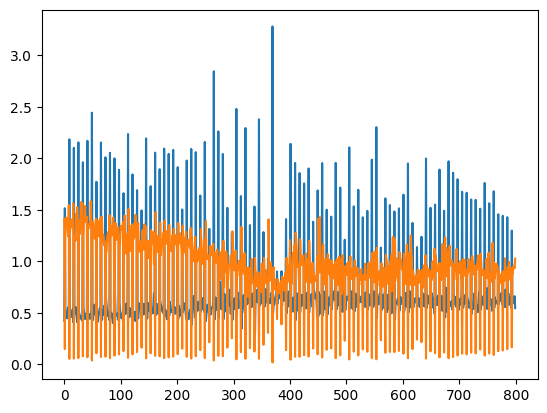

In [ ]:
from PIL import Image
import matplotlib.pylab as plt

test_samples = test_samples.detach().cpu().numpy()
im = Image.fromarray(np.squeeze(test_samples[0, :, :, :]))
# im.show()

plt.plot(d_loss, label="D")
plt.plot(g_loss, label="G")
plt.show()

In [ ]:
im2 = Image.fromarray(np.squeeze(test_samples[15, :, :, :]))
ims = []
for k in range(25):
  ims.append(Image.fromarray(np.squeeze(test_samples[k, :, :, :])))

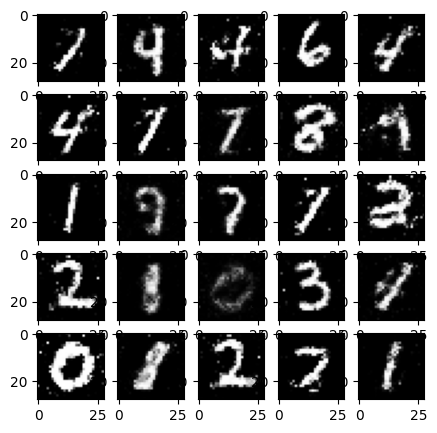

In [ ]:
plt.figure(figsize=(5, 5))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(ims[i])
# plt.subplot(4,4,1)
# plt.imshow(im)
# plt.subplot(4,4,2)
# plt.imshow(im2)
plt.show()